In [1]:
import numpy as np # linear algebra
from numpy import log

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

import math

from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller #for Stationarity


import pmdarima as pm # Auto TimeSeries

from sklearn.metrics import mean_absolute_error, mean_squared_error #Error Metrics
import warnings # Supress warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

#string to date format
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)
df = df.set_index(['Month'])
df.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.shape

(144, 1)

In [4]:
df.rename(columns = {'#Passengers':'Passengers'}, inplace = True)

In [5]:
df.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
# ### visualizing graph to see the components

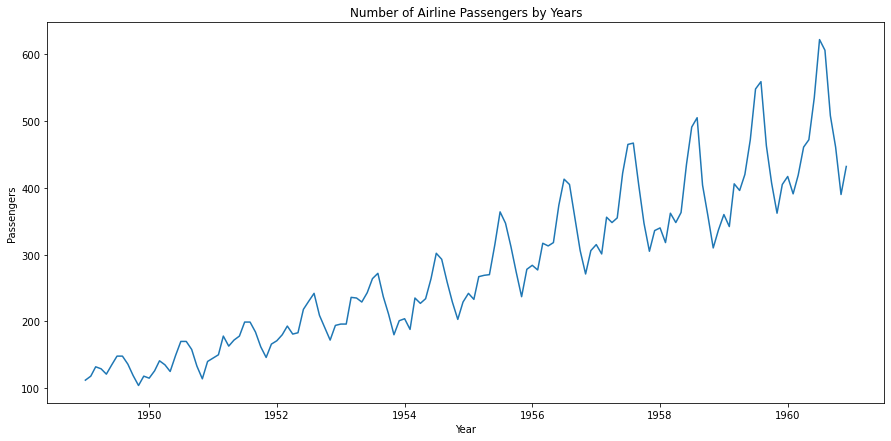

In [6]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Years")
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

In [7]:
df_train = df[:134]
df_test = df[134:]

In [ ]:
#### Stationarity check

In [10]:
def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    
    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Years')
    plt.ylabel('Open')    
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')   
    plt.legend()
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries)

    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

    adf = df_test[0]
    pvalue = df_test[1]
    critical_value = df_test[4]['5%']
    if(pvalue < 0.05) and (adf < critical_value):
        print("The Series is STATIONARY")
    else:
        print("The Series is NOT Stationary")

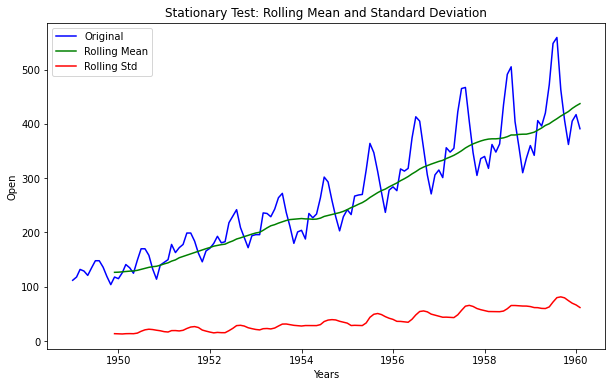

Results of Dickey-Fuller Test
Test Statistic                   0.818516
p-value                          0.991929
#Lags Used                      13.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64
The Series is NOT Stationary


In [11]:
# Lets test the stationarity score with original series data
stationarity_test(df_train)

In [ ]:
### Using Differencing to make data Stationary

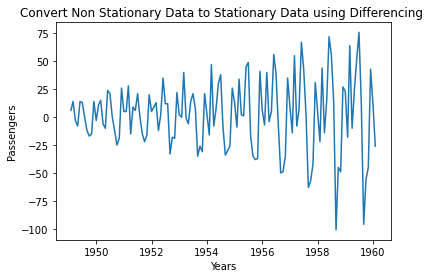

In [12]:
df_train_diff = df_train.diff(periods = 1) # First order differencing
plt.xlabel('Years')
plt.ylabel('Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_train_diff)

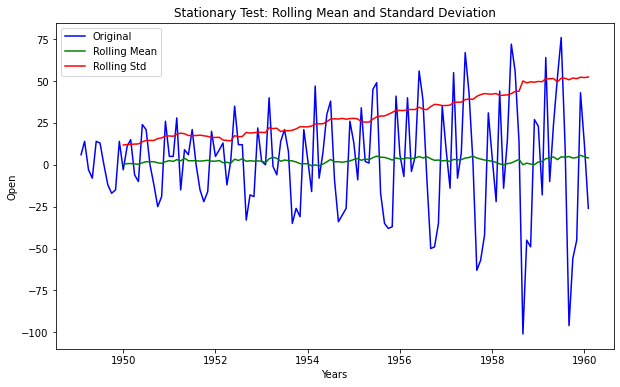

Results of Dickey-Fuller Test
Test Statistic                  -2.737820
p-value                          0.067719
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64
The Series is NOT Stationary


In [13]:
df_train_diff.dropna(inplace = True)# Data transformation may add na values
stationarity_test(df_train_diff)


In [ ]:
#### Likewise we can 2nd order differencing(if the data is not stationary in the 1st order differencing

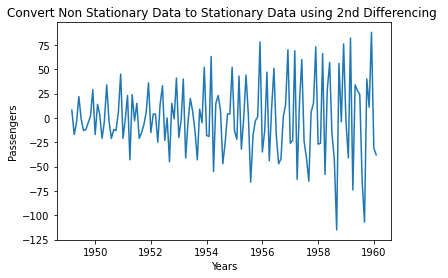

In [14]:
df_train_diff2 = df_train_diff.diff(periods = 1) # second order differencing
plt.xlabel('Years')
plt.ylabel('Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using 2nd Differencing ')
plt.plot(df_train_diff2)

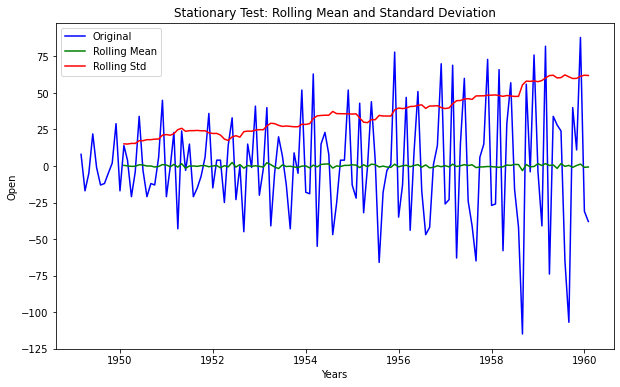

Results of Dickey-Fuller Test
Test Statistic                -1.422054e+01
p-value                        1.660794e-26
#Lags Used                     1.100000e+01
Number of Observations Used    1.200000e+02
Critical Value (1%)           -3.486056e+00
Critical Value (5%)           -2.885943e+00
Critical Value (10%)          -2.579785e+00
dtype: float64
The Series is STATIONARY


In [15]:
df_train_diff2.dropna(inplace = True)# Data transformation may add na values
stationarity_test(df_train_diff2)

In [16]:
### Additionally we can use transformation techniques like Log, exponential etc for smoothing the data.

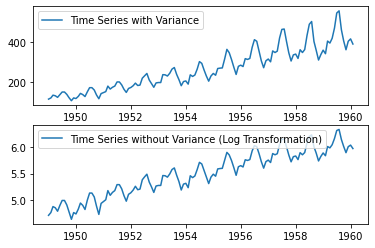

In [17]:

df_train_log = np.log(df_train)

plt.subplot(211)
plt.plot(df_train, label= 'Time Series with Variance')
plt.legend()
plt.subplot(212)
plt.plot(df_train_log, label='Time Series without Variance (Log Transformation)')
plt.legend()  
plt.show()


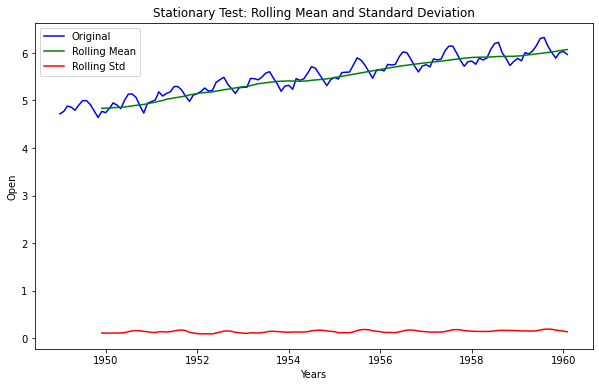

Results of Dickey-Fuller Test
Test Statistic                  -1.449889
p-value                          0.558139
#Lags Used                      13.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64
The Series is NOT Stationary


In [18]:
stationarity_test(df_train_log)


In [ ]:
### Rolling mean on the log data (Moving Average)

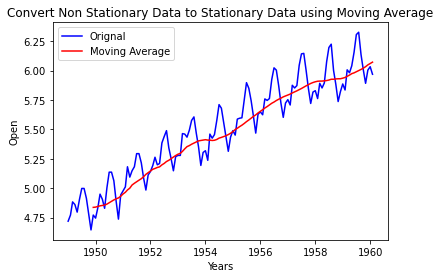

In [19]:
df_train_log_moving_avg = df_train_log.rolling(window = 12).mean()
plt.xlabel('Years')
plt.ylabel('Open')    
plt.title('Convert Non Stationary Data to Stationary Data using Moving Average')
plt.plot(df_train_log, color= 'blue', label='Orignal')
plt.plot(df_train_log_moving_avg, color= 'red', label='Moving Average')
plt.legend()

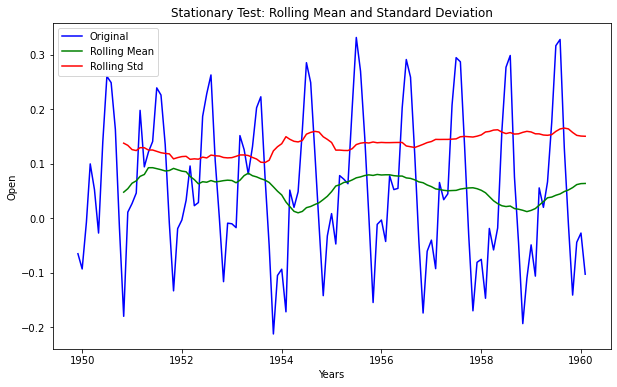

Results of Dickey-Fuller Test
Test Statistic                  -3.087344
p-value                          0.027504
#Lags Used                      13.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64
The Series is STATIONARY


In [20]:
df_train_log_moving_avg_diff = df_train_log - df_train_log_moving_avg
df_train_log_moving_avg_diff.dropna(inplace = True)
stationarity_test(df_train_log_moving_avg_diff)


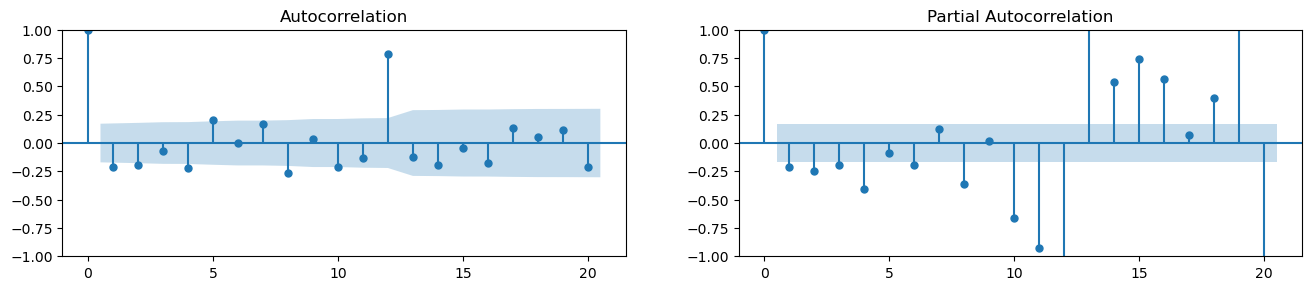

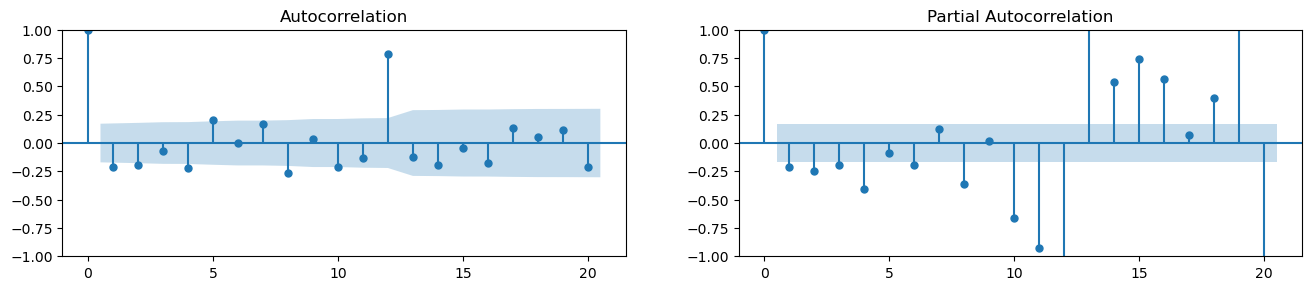

In [21]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_train_diff2['Passengers'].tolist(), lags=20, ax=axes[0])
plot_pacf(df_train_diff2['Passengers'].tolist(), lags=20, ax=axes[1])

In [ ]:
# Take the first difference to remove to make the process stationary
#data_diff = df.Passengers - df.Passengers.shift(1)

In [ ]:
#### Building ARIMA

In [22]:
from statsmodels.tsa.arima.model import ARIMA


In [23]:
model1 = ARIMA(df_train, order = (14,2,6)) 
results_ARIMA = model1.fit()
print(results_ARIMA.summary())


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  134
Model:                ARIMA(14, 2, 6)   Log Likelihood                -499.635
Date:                Thu, 03 Nov 2022   AIC                           1041.271
Time:                        23:34:09   BIC                           1101.809
Sample:                    01-01-1949   HQIC                          1065.871
                         - 02-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7252      2.196     -0.330      0.741      -5.029       3.578
ar.L2          0.0217      1.871      0.012      0.991      -3.646       3.689
ar.L3         -0.0545      1.709     -0.032      0.9

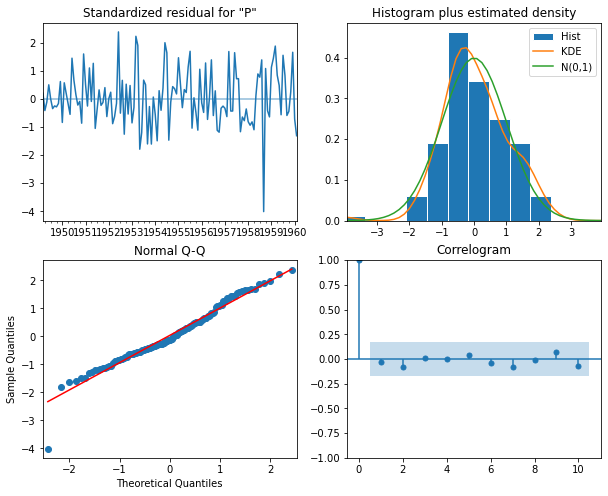

In [24]:
results_ARIMA.plot_diagnostics(figsize=(10,8))
plt.show()


In [25]:
pred = results_ARIMA.predict()

In [26]:
type(pred)

pandas.core.series.Series

In [27]:
pred

1949-01-01      0.000000
1949-02-01    168.038878
1949-03-01    124.007278
1949-04-01    145.543368
1949-05-01    125.296131
                 ...    
1959-10-01    411.391627
1959-11-01    359.468125
1959-12-01    388.695808
1960-01-01    424.076519
1960-02-01    403.921062
Freq: MS, Name: predicted_mean, Length: 134, dtype: float64

In [28]:
pred = pred.to_frame()
pred.head()

,predicted_mean
1949-01-01,0.000000
1949-02-01,168.038878
1949-03-01,124.007278
1949-04-01,145.543368
1949-05-01,125.296131


In [29]:
pred.head(5)

,predicted_mean
1949-01-01,0.000000
1949-02-01,168.038878
1949-03-01,124.007278
1949-04-01,145.543368
1949-05-01,125.296131


In [30]:
pred.tail(5)

,predicted_mean
1959-10-01,411.391627
1959-11-01,359.468125
1959-12-01,388.695808
1960-01-01,424.076519
1960-02-01,403.921062


In [31]:
print("Train MAPE: ",mean_absolute_percentage_error(df_train.Passengers,pred.predicted_mean))

NameError: name 'mean_absolute_percentage_error' is not defined

In [32]:
print("Train MSE: ",mean_squared_error(df_train.Passengers,pred.predicted_mean))

Train MSE:  214.86367566157898


In [33]:
forecast_test = results_ARIMA.forecast(10)

In [34]:
forecast_test = forecast_test.to_frame()
forecast_test.head()

,predicted_mean
1960-03-01,442.144384
1960-04-01,438.224599
1960-05-01,465.072004
1960-06-01,518.550257
1960-07-01,592.627742


In [35]:
forecast_test.head(10)

,predicted_mean
1960-03-01,442.144384
1960-04-01,438.224599
1960-05-01,465.072004
1960-06-01,518.550257
1960-07-01,592.627742
1960-08-01,603.486940
1960-09-01,513.176968
1960-10-01,454.719068
1960-11-01,413.269821
1960-12-01,455.557160


In [36]:
print("Test MAPE: ",mean_absolute_percentage_error(df_test.Passengers,forecast_test.predicted_mean))

NameError: name 'mean_absolute_percentage_error' is not defined

In [37]:
print("Test MSE: ",mean_squared_error(df_test.Passengers,forecast_test.predicted_mean))

Test MSE:  340.4693041000675


Text(0.5, 1.0, 'forecasting the Time Series')

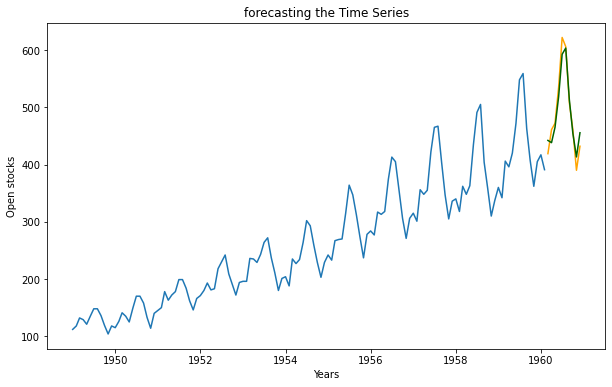

In [38]:
plt.figure(figsize= (10,6))
plt.plot(df_train.Passengers)
plt.plot(df_test.Passengers,color="orange")
plt.plot(forecast_test.predicted_mean,color="darkgreen")
plt.xlabel('Years')
plt.ylabel('Open stocks')
plt.title('forecasting the Time Series')

In [39]:
#### Auto ARIMA on Train dataset

In [40]:
model2 = pm.auto_arima(df_train, 
                      trace=True,
                      )

print(model2.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1241.041, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1295.940, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1286.658, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1282.753, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1294.543, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1275.953, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1245.123, Time=0.39 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 6.338

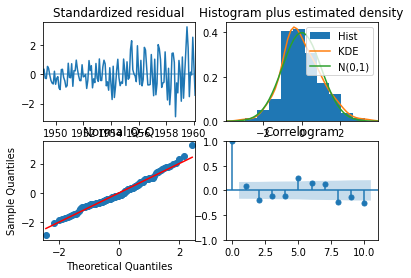

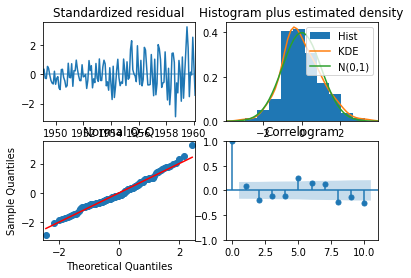

In [41]:
model2.plot_diagnostics()

In [42]:
test_pred_2 = model2.predict()

In [43]:
test_pred_2= test_pred_2.to_frame()
test_pred_2.head()

,0
1960-03-01,414.126092
1960-04-01,444.990216
1960-05-01,475.199128
1960-06-01,497.670862
1960-07-01,508.290428


In [44]:
test_pred_2.rename(columns={0:"Prediction"},inplace=True)

In [45]:
print("Test MAPE on Model2: ", mean_absolute_percentage_error(df_test.Passengers,test_pred_2.Prediction))

NameError: name 'mean_absolute_percentage_error' is not defined

In [46]:
print("Test MSE on Model2: ", mean_squared_error(df_test.Passengers,test_pred_2.Prediction))

Test MSE on Model2:  3097.4034405677126


In [ ]:
##In Multiplicative model, we assume that all the components of the time series are dependent and in Additive model it is assumed that the components are independent.

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
# Multiplicative Decomposition 

In [48]:
multiplicative_decomposition = seasonal_decompose(df['Passengers'], model='multiplicative', period=30)

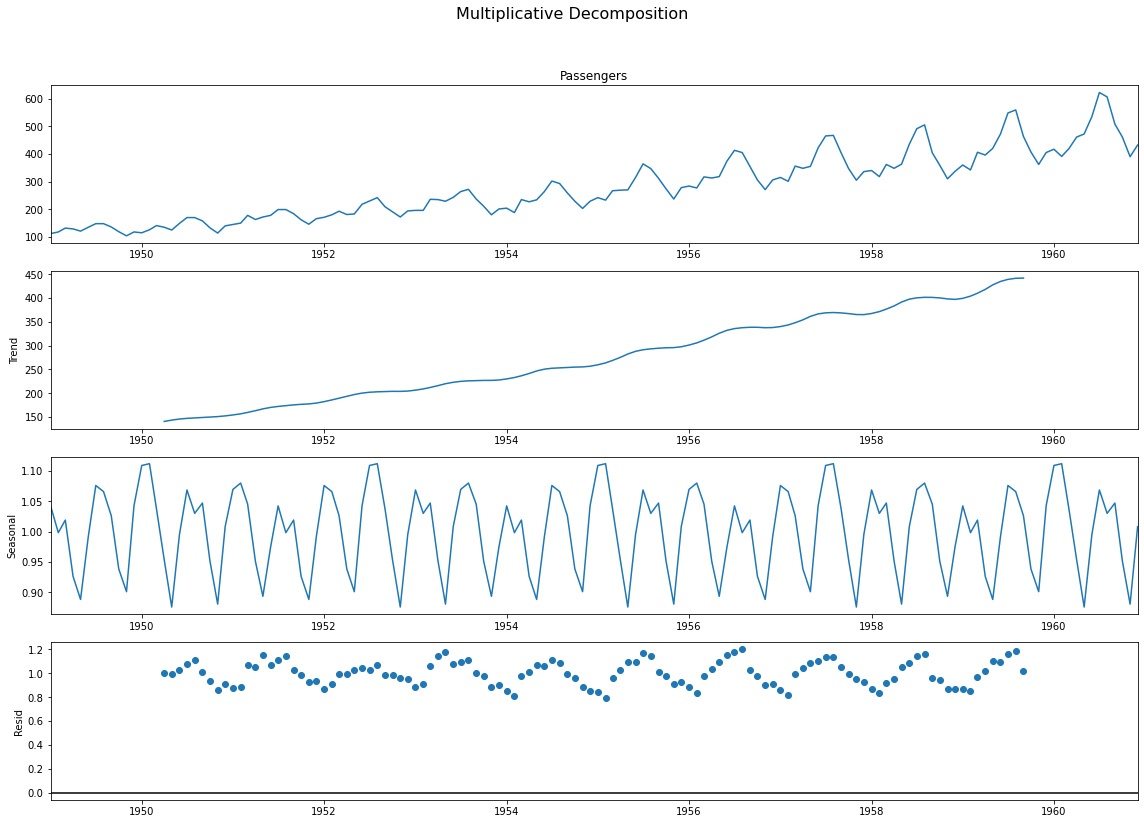

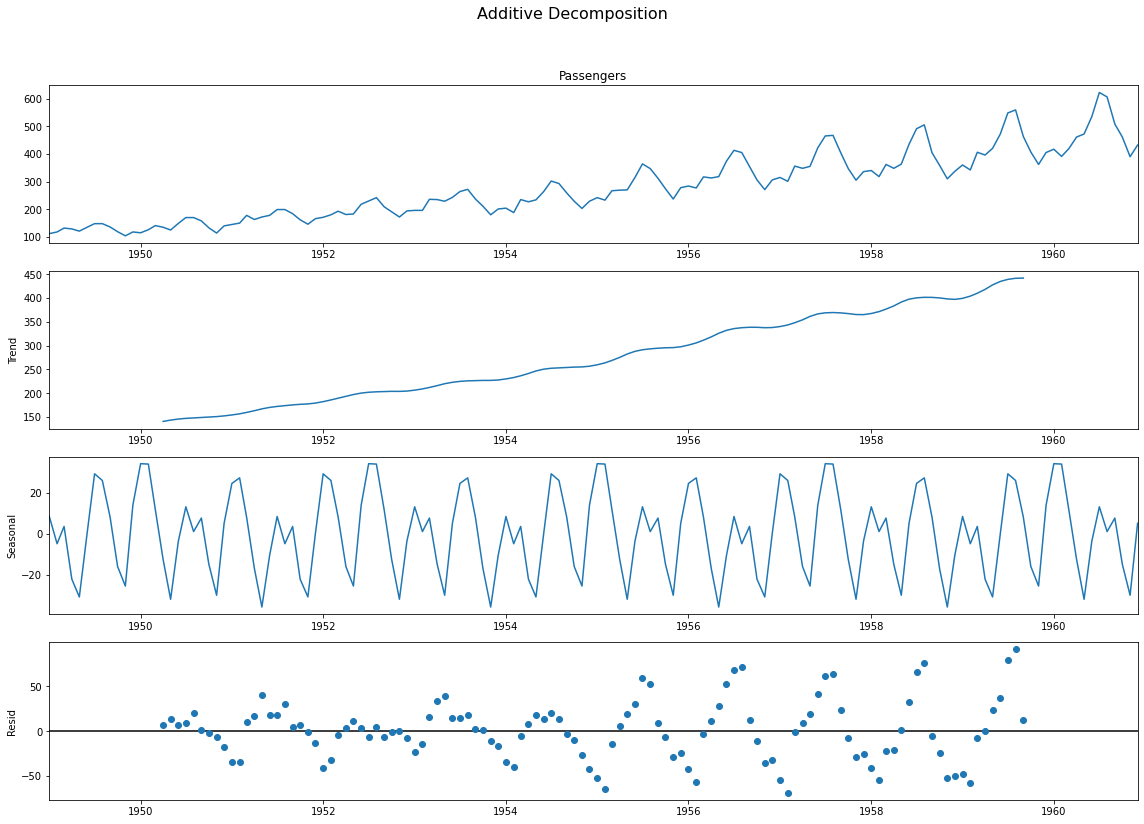

In [49]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(df['Passengers'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [ ]:
### Detrend

Text(0.5, 1.0, 'Air Passengers detrended ')

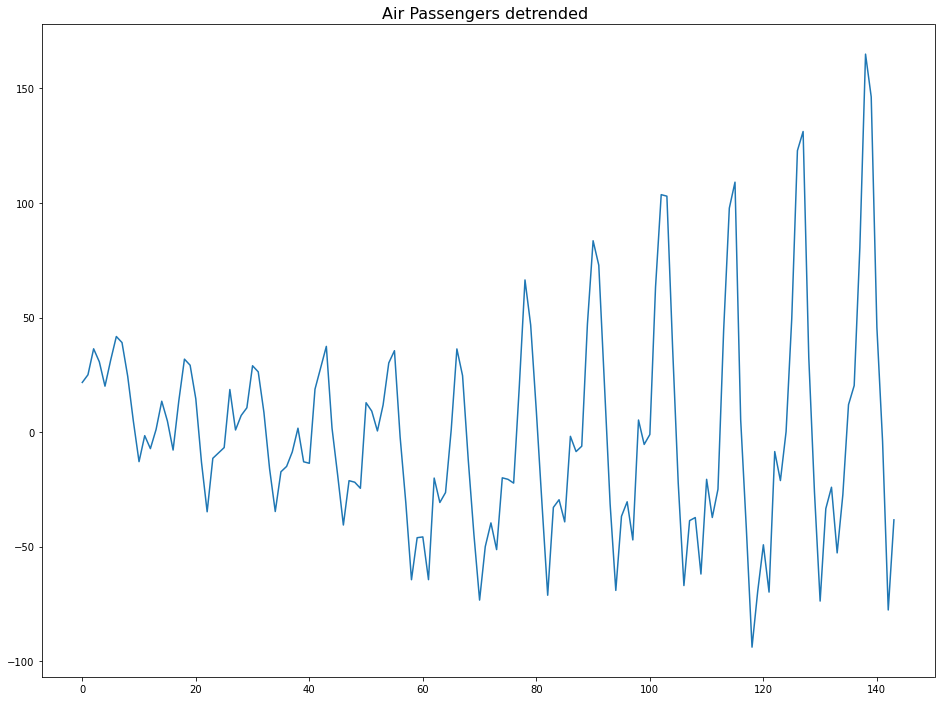

In [50]:
# Using scipy: Subtract the line of best fit using least squares
from scipy import signal
detrended = signal.detrend(df['Passengers'].values)
plt.plot(detrended)
plt.title('Air Passengers detrended ', fontsize=16)

Text(0.5, 1.0, 'Air Passengers detrended by subtracting the trend component')

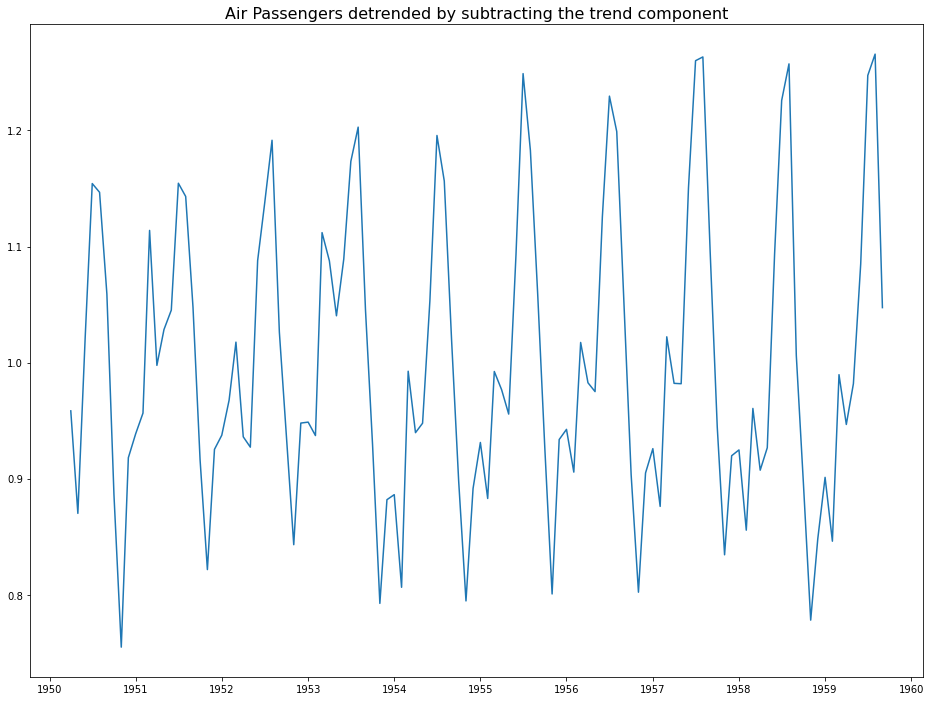

In [51]:
# Using statmodels: Subtracting the Trend Component
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(df['Passengers'], model='multiplicative', period=30)
detrended = df['Passengers'].values / result_mul.trend
plt.plot(detrended)
plt.title('Air Passengers detrended by subtracting the trend component', fontsize=16)

[]

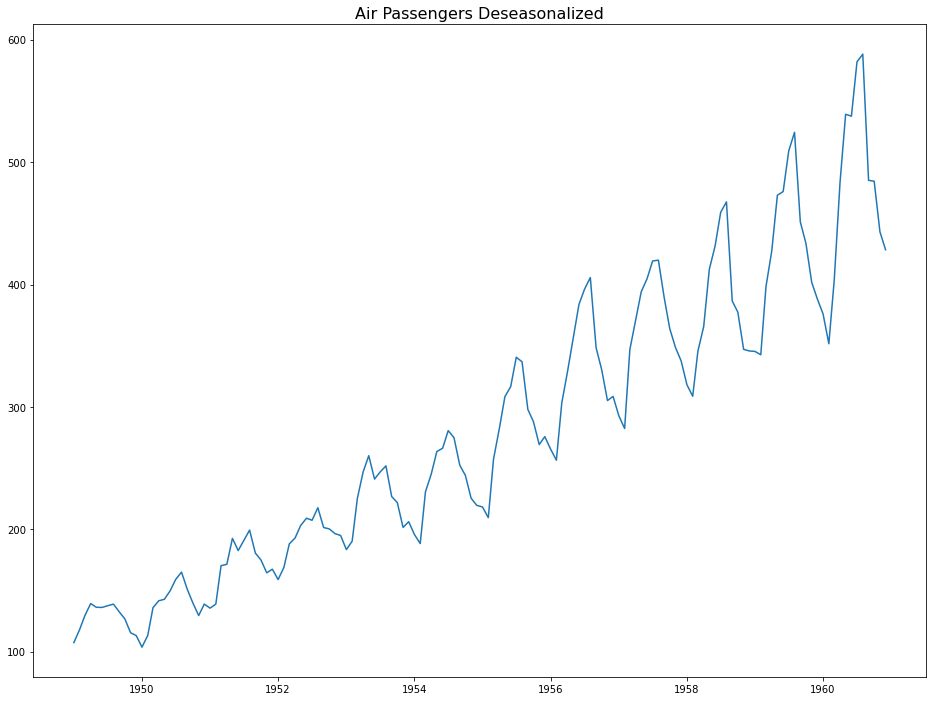

In [52]:
# Subtracting the seasonal Component

# Time Series Decomposition
result_mul = seasonal_decompose(df['Passengers'], model='multiplicative', period=30)


# Deseasonalize
deseasonalized = df['Passengers'].values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Air Passengers Deseasonalized', fontsize=16)
plt.plot()

[]

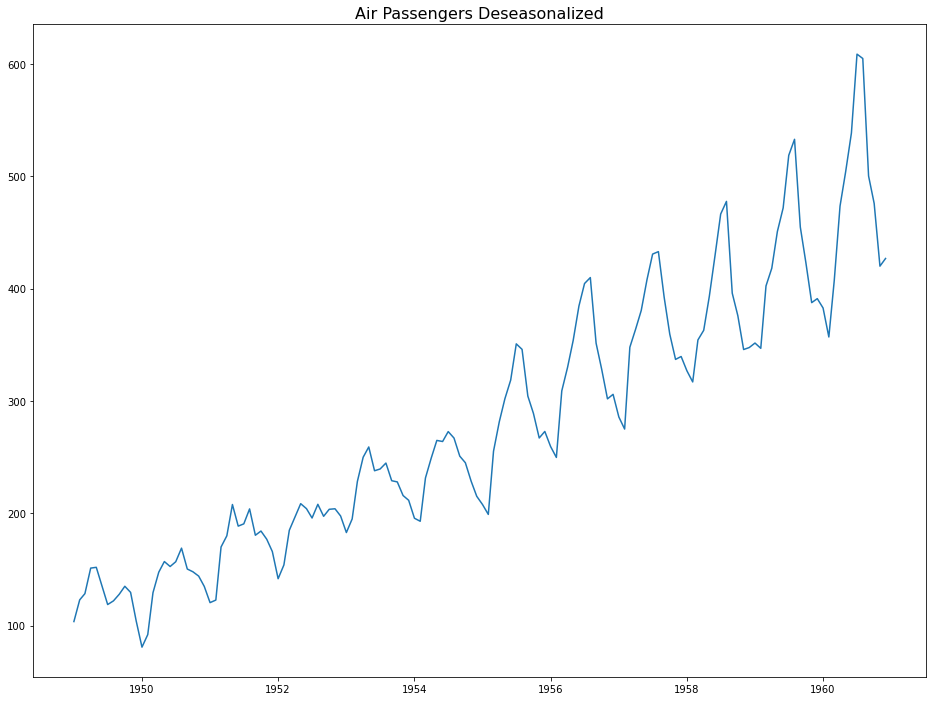

In [53]:
# Substracting Seasoanl component
# Time Series Decomposition
result_add = seasonal_decompose(df['Passengers'], model='additive', period=30)

# Deseasonalize
deseasonalized_add = df['Passengers'].values - result_add.seasonal

# Plot
plt.plot(deseasonalized_add)
plt.title('Air Passengers Deseasonalized', fontsize=16)
plt.plot()


In [54]:
desea_df = deseasonalized.to_frame()



In [55]:
desea_df

,seasonal
Month,
1949-01-01,107.439375
1949-02-01,118.201835
1949-03-01,129.528342
1949-04-01,139.281653
1949-05-01,136.253417
...,...
1960-08-01,588.258633
1960-09-01,485.130889
1960-10-01,484.429770


In [56]:
train_desea = desea_df[:134]
test_desea = desea_df[134:]

In [57]:
#### Testing Stationarity on data after removing decomposition value


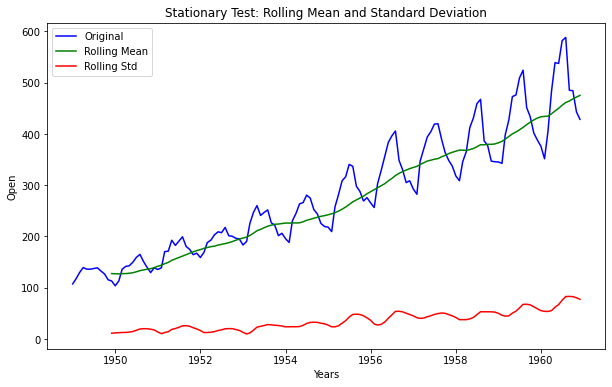

Results of Dickey-Fuller Test
Test Statistic                   1.697193
p-value                          0.998122
#Lags Used                      12.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64
The Series is NOT Stationary


In [58]:
stationarity_test(deseasonalized)

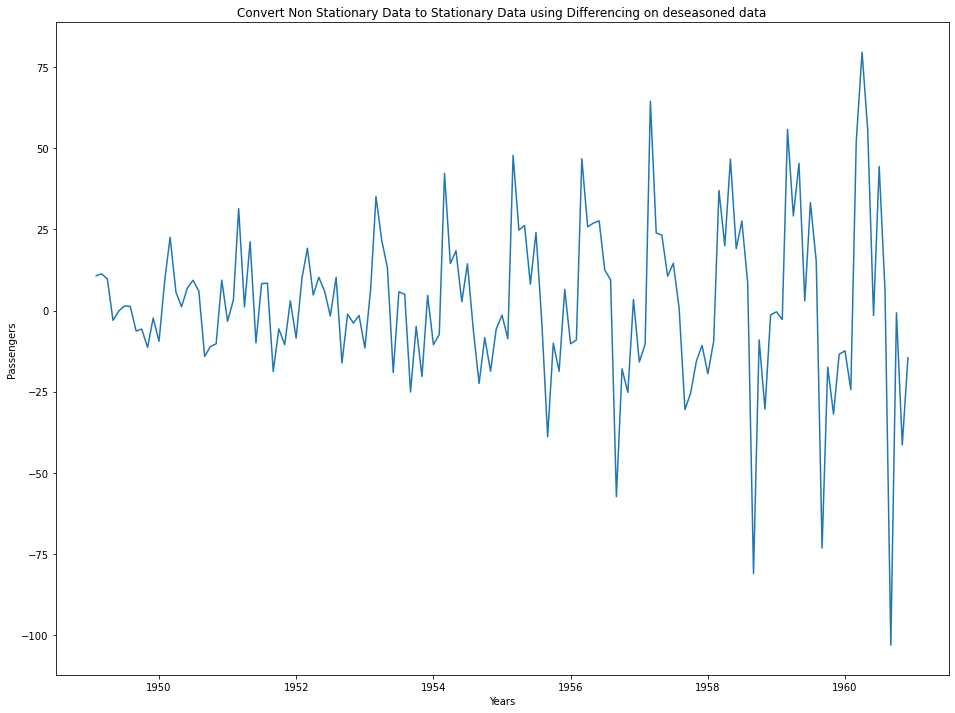

In [59]:
deseasonalized_diff = deseasonalized.diff(periods = 1) # First order differencing
plt.xlabel('Years')
plt.ylabel('Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using Differencing on deseasoned data')
plt.plot(deseasonalized_diff)

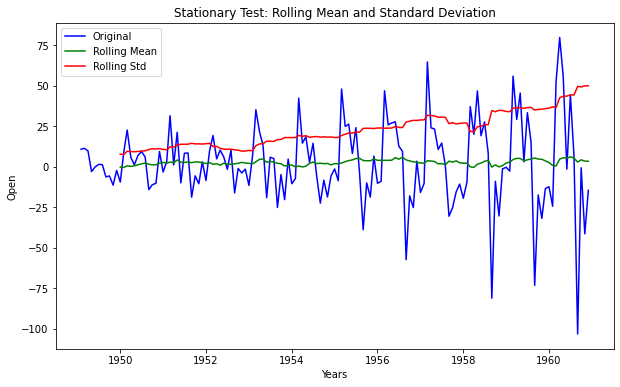

Results of Dickey-Fuller Test
Test Statistic                  -2.805989
p-value                          0.057423
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64
The Series is NOT Stationary


In [60]:
deseasonalized_diff.dropna(inplace = True)# Data transformation may add na values

stationarity_test(deseasonalized_diff)

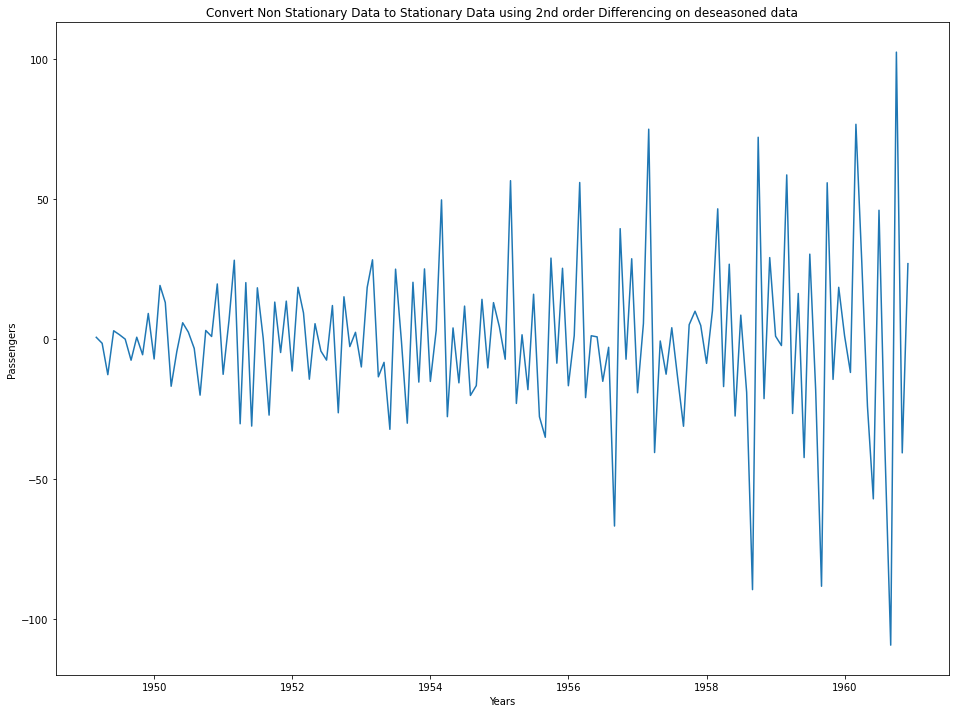

In [61]:
deseasonalized_diff2 = deseasonalized_diff.diff(periods = 1) # Second order differencing
plt.xlabel('Years')
plt.ylabel('Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using 2nd order Differencing on deseasoned data')
plt.plot(deseasonalized_diff2)

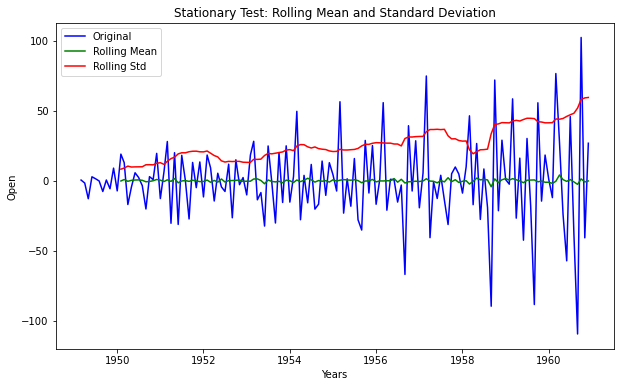

Results of Dickey-Fuller Test
Test Statistic                -7.982758e+00
p-value                        2.596827e-12
#Lags Used                     1.400000e+01
Number of Observations Used    1.270000e+02
Critical Value (1%)           -3.482920e+00
Critical Value (5%)           -2.884580e+00
Critical Value (10%)          -2.579058e+00
dtype: float64
The Series is STATIONARY


In [62]:
deseasonalized_diff2.dropna(inplace = True)# Data transformation may add na values

stationarity_test(deseasonalized_diff2)


In [63]:
deseasonalized_diff2

Month
1949-03-01      0.564045
1949-04-01     -1.573194
1949-05-01    -12.781548
1949-06-01      2.903338
1949-07-01      1.522561
                 ...    
1960-08-01    -38.153758
1960-09-01   -109.391891
1960-10-01    102.426625
1960-11-01    -40.713534
1960-12-01     26.869778
Name: seasonal, Length: 142, dtype: float64

In [64]:
deseasonalized_diff2 = deseasonalized_diff2.to_frame()
deseasonalized_diff2.head()


,seasonal
Month,
1949-03-01,0.564045
1949-04-01,-1.573194
1949-05-01,-12.781548
1949-06-01,2.903338
1949-07-01,1.522561


In [ ]:
#### Auto ARIMA On Decomposed Multiplicative data


In [65]:
model_3 = pm.auto_arima(train_desea,trace=True)
print(model_3.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1201.931, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1189.224, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1193.350, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1200.865, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1188.200, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1188.758, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1189.783, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1186.515, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1187.670, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1187.158, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1188.144, T

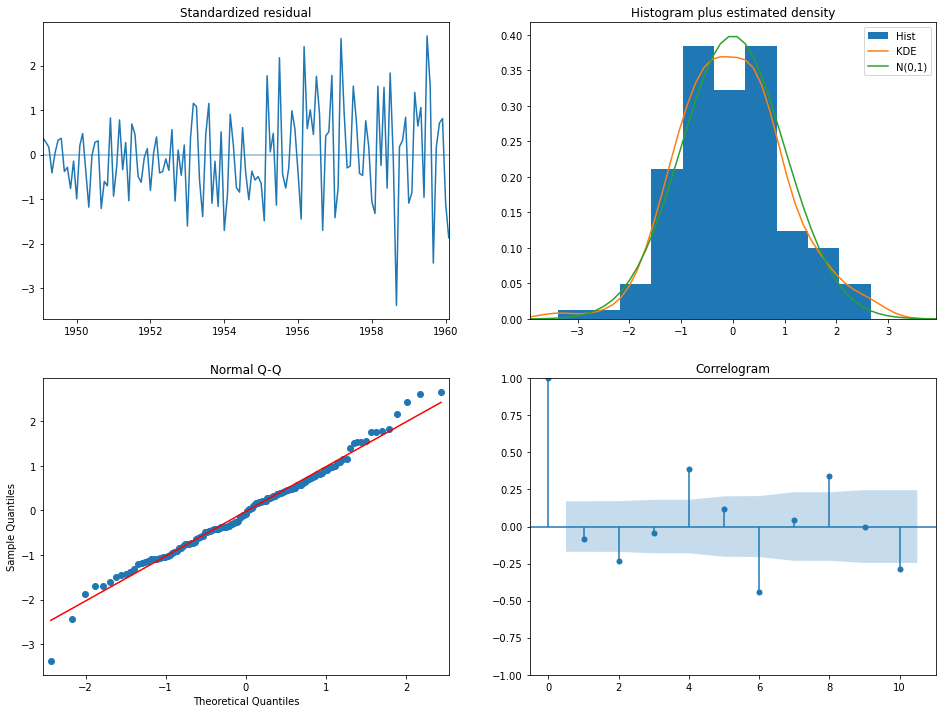

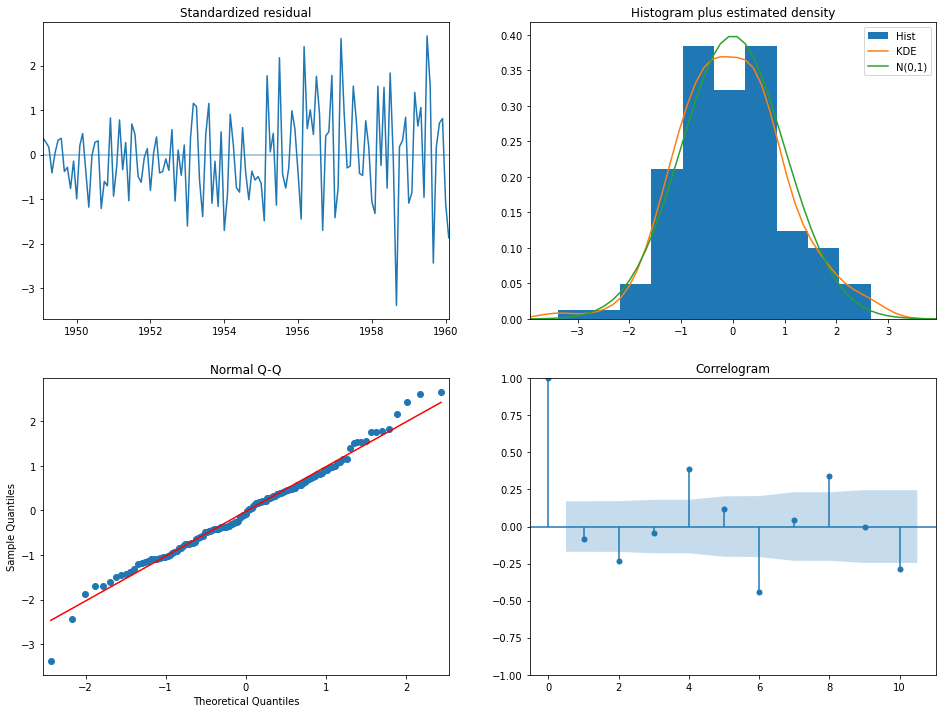

In [66]:
model_3.plot_diagnostics()


In [67]:
pred_test_sea_3 = model_3.predict()

In [68]:
pred_test_sea_3 = pred_test_sea_3.to_frame()
pred_test_sea_3.head()

,0
1960-03-01,378.911212
1960-04-01,401.320627
1960-05-01,436.338065
1960-06-01,471.572867
1960-07-01,491.643969


In [69]:
pred_test_sea_3.rename(columns={0:"Prediction"},inplace=True)

In [70]:
print("Test MAPE : ",mean_absolute_percentage_error(test_desea.seasonal,pred_test_sea_3.Prediction)) #without Seasonality component to predictions

NameError: name 'mean_absolute_percentage_error' is not defined

In [71]:
print("Train MSE : ",mean_squared_error(test_desea.seasonal,pred_test_sea_3.Prediction)) #without Seasonality component to predictions

Train MSE :  3846.267018750196


In [ ]:
 #### Additive Train test split


In [72]:
desea_df_add = deseasonalized_add.to_frame()
desea_df_add.head()


,seasonal
Month,
1949-01-01,103.587407
1949-02-01,122.891574
1949-03-01,128.445741
1949-04-01,151.187407
1949-05-01,151.887407


In [73]:
train_desea_add = desea_df_add[:134]
test_desea_add = desea_df_add[134:]

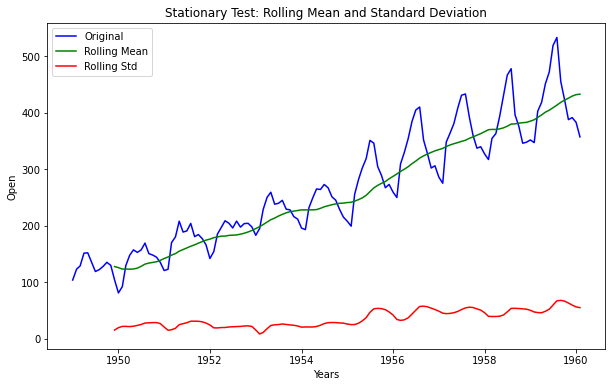

Results of Dickey-Fuller Test
Test Statistic                   0.296605
p-value                          0.977188
#Lags Used                      12.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64
The Series is NOT Stationary


In [74]:
stationarity_test(train_desea_add)

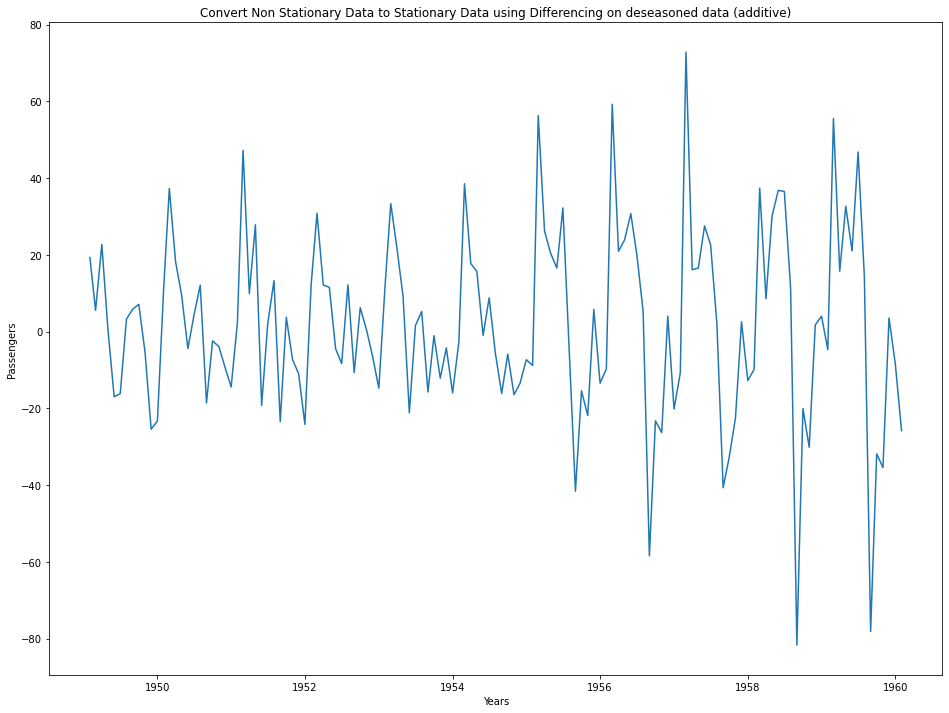

In [75]:
train_desea_add_diff = train_desea_add.diff(periods = 1) # First order differencing
plt.xlabel('Years')
plt.ylabel('Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using Differencing on deseasoned data (additive)')
plt.plot(train_desea_add_diff)


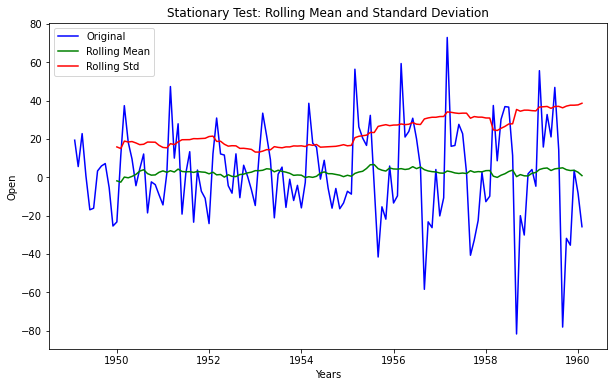

Results of Dickey-Fuller Test
Test Statistic                  -4.408582
p-value                          0.000287
#Lags Used                      11.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64
The Series is STATIONARY


In [76]:
train_desea_add_diff.dropna(inplace = True)# Data transformation may add na values

stationarity_test(train_desea_add_diff)

In [ ]:
### Auto ARIMA on Decomposed Additive data


In [77]:
model_4 = pm.auto_arima(train_desea_add,trace=True)

print(model_4.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1200.262, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1228.842, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1214.187, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1215.913, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1227.665, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1216.520, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1177.255, Time=1.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1188.755, Time=1.32 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1207.693, Time=0.34 s

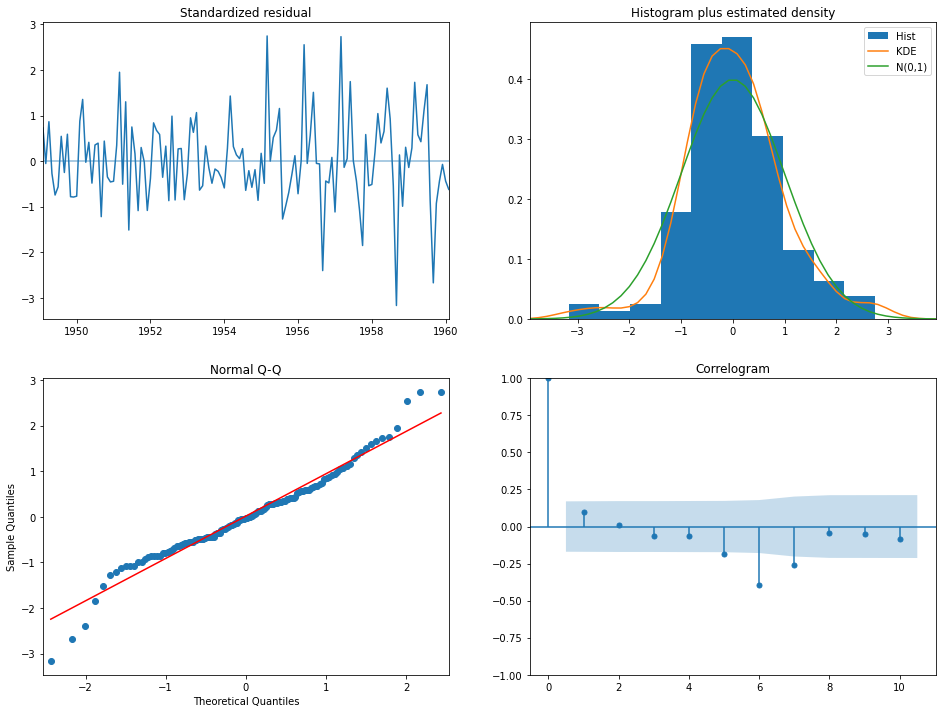

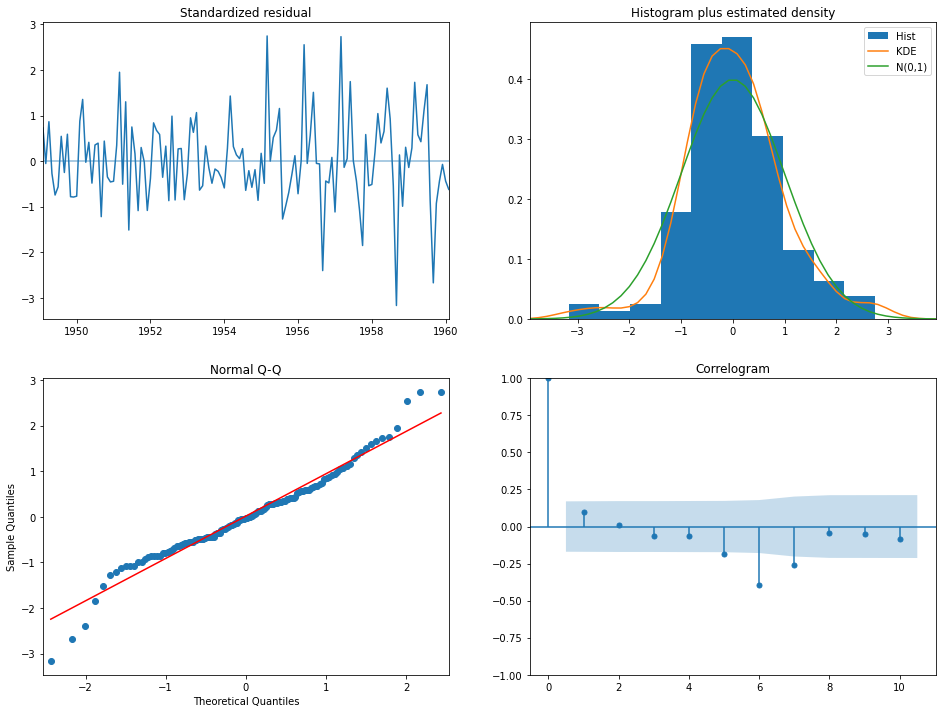

In [78]:
model_4.plot_diagnostics()

In [79]:
pred_test_sea_4 = model_4.predict()

In [80]:
pred_test_sea_4 = pred_test_sea_4.to_frame()
pred_test_sea_4.head()


,0
1960-03-01,366.814910
1960-04-01,349.286443
1960-05-01,366.735748
1960-06-01,358.836730
1960-07-01,360.145726


In [81]:
pred_test_sea_4.rename(columns={0:"Prediction"},inplace=True)

In [82]:
print("Test MAPE : ",mean_absolute_percentage_error(test_desea_add.seasonal,pred_test_sea_4.Prediction)) #without Seasonality component to predictions

NameError: name 'mean_absolute_percentage_error' is not defined

In [83]:
print("Test MSE : ",mean_squared_error(test_desea_add.seasonal,pred_test_sea_4.Prediction)) #without Seasonality component to predictions


Test MSE :  22240.99892691013


In [84]:
#### SARIMAX

In [85]:
model_5 = sm.tsa.statespace.SARIMAX(df_train,order=(2,1,2), seasonal_order=(2,1,2,12),

                                 enforce_stationarity=False, enforce_invertibility=False,).fit()

model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  134
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -354.705
Date:                            Thu, 03 Nov 2022   AIC                            727.410
Time:                                    23:50:43   BIC                            750.300
Sample:                                01-01-1949   HQIC                           736.656
                                     - 02-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0835      0.922      0.091      0.928      -1.724       1.891
ar.L2          0.3044      0.323      0.944      0.345      -0.328       0.937
ma.L1         -0.4444      0.963     -0.461      0.645      -2.332       1.443
ma.L2         -0.1945      0.412     -0.472      0.637      -1.002       0.613
ar.S.L12       0.1882      0.165      1.138      0.255      -0.136       0.512
ar.S.L24       0.7208      0.142      5.069      0.000       0.442       1.000
ma.S.L12      -0.3916   8137.341  -4.81e-05      1.000   -1.59e+04    1.59e+04
ma.S.L24      -0.6084   4950.608     -0.000      1.000   -9703.622    9702.405
sigma2        89.3723   7.27e+05      0.000      1.000   -1.43e+06    1.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.94   Prob(JB):                         0.77
Heteroskedasticity (H):               1.27   Skew:                            -0.06
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#model_5 = pm.auto_arima(df_train,seasonality=True,trace=True)

#print(model_5.summary())


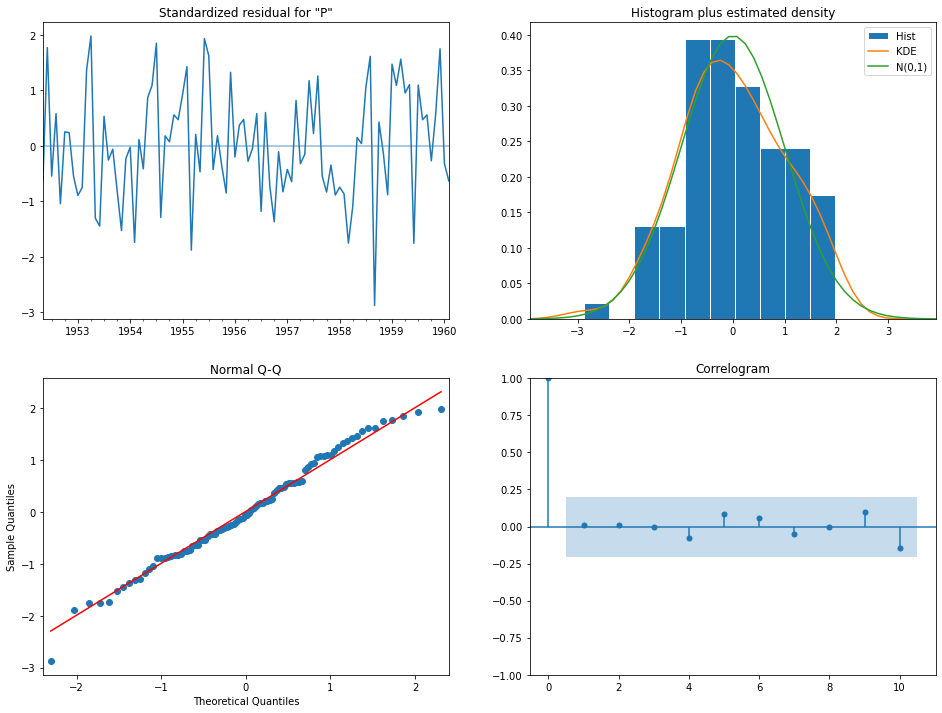

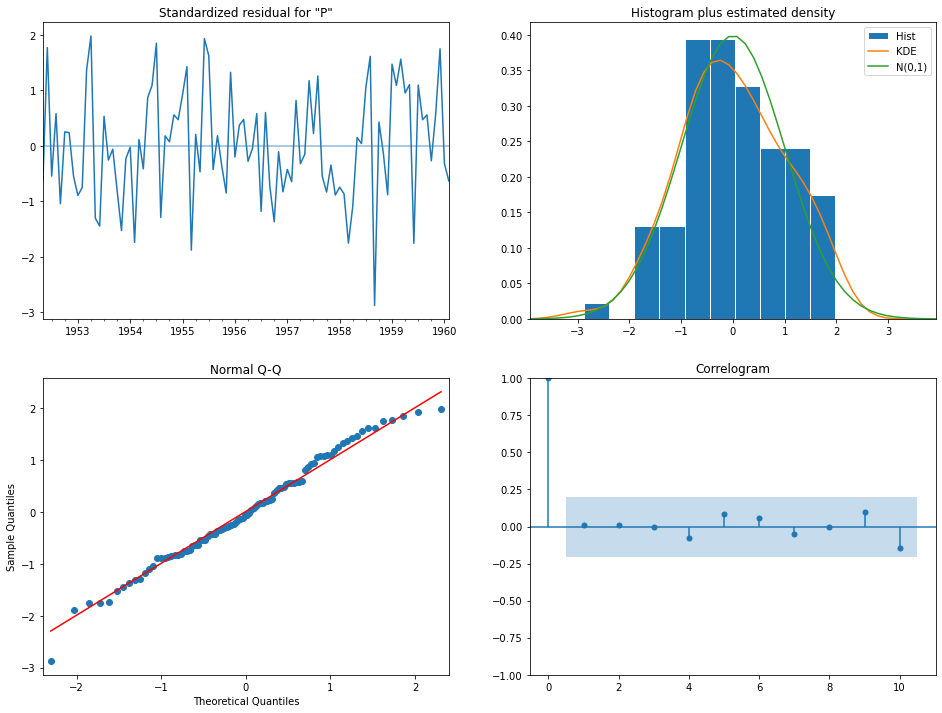

In [86]:
model_5.plot_diagnostics()


In [87]:
pred_train_sea_5 = model_5.predict()

In [88]:
pred_train_sea_5 = pred_train_sea_5.to_frame()
pred_train_sea_5.head()


,predicted_mean
1949-01-01,0.000000
1949-02-01,115.116926
1949-03-01,129.770584
1949-04-01,134.484005
1949-05-01,132.865341


In [ ]:
#pred_train_sea_5.rename(columns={0:"Prediction"},inplace=True)


In [ ]:
print("Test MAPE : ",mean_absolute_percentage_error(df_train.Passengers,pred_train_sea_5.predicted_mean)) #without Seasonality component to predictions


In [89]:
print("Test MSE : ",mean_squared_error(df_train.Passengers,pred_train_sea_5.predicted_mean)) #without Seasonality component to predictionshow t

Test MSE :  261.11603722672766


In [90]:
forecast_test = model_5.forecast(10)

In [91]:
forecast_test = forecast_test.to_frame()

In [92]:
print("Test MAPE : ",mean_absolute_percentage_error(df_test.Passengers,forecast_test.predicted_mean)) #without Seasonality component to predictions

NameError: name 'mean_absolute_percentage_error' is not defined

In [93]:
print("Test MSE : ",mean_squared_error(df_test.Passengers,forecast_test.predicted_mean)) #without Seasonality component to predictionshow t

Test MSE :  280.22247678969177


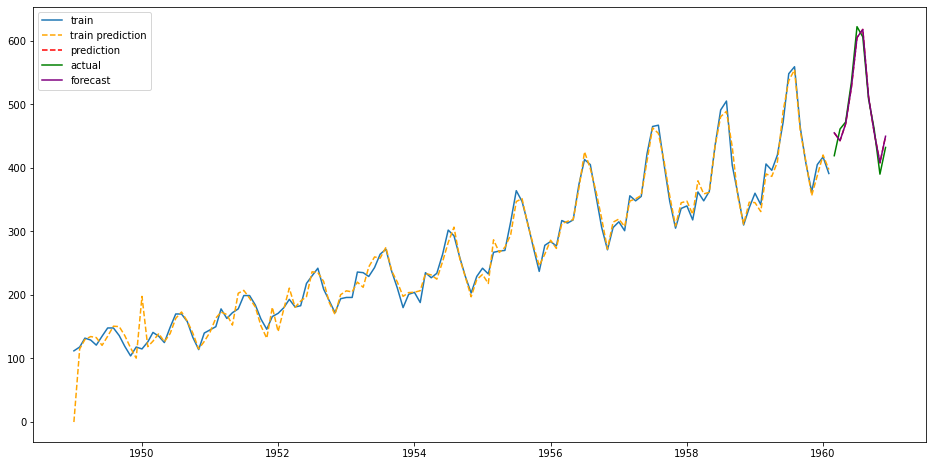

In [95]:
pred_train = model_5.predict(df_train.index.min(), df_train.index.max())

pred_test = model_5.predict(df_test.index.min(), df_test.index.max())

#plt.title('ARIMA model MSE:{}'.format(mean_squared_error(test,pred_test)))

plt.figure(figsize=(16,8))

plt.plot(df_train, label='train')

plt.plot(pred_train, color='orange', linestyle='--', label= 'train prediction')

plt.plot(pred_test, color='red', linestyle='--', label= 'prediction')

plt.plot(df_test, color='green', label='actual')

plt.plot(forecast_test.predicted_mean, color='purple', linestyle='-', label= 'forecast')

plt.legend(loc='best')

plt.show()